In [26]:
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
#https://pyramid-arima.readthedocs.io/en/latest/_submodules/arima.html
import numpy
from numpy import newaxis
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pyramid.arima import auto_arima

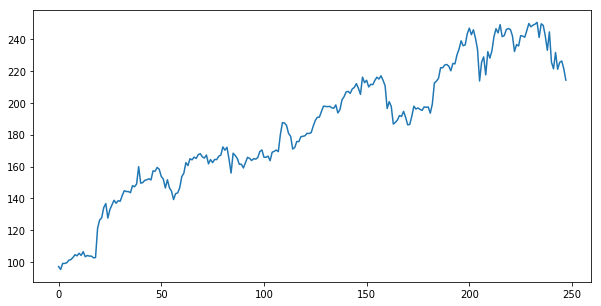

In [27]:
dataset = pandas.read_csv('NVDA.csv', usecols=[1], engine='python', skipfooter=3)
dataset = numpy.flipud(dataset)[1::]
plt.figure(figsize=(10,5))
plt.plot(dataset)
plt.show()
#dataset = dataframe.values
dataset = dataset.astype('float32')

In [28]:
# fix random seed for reproducibility
#numpy.random.seed(7)

In [29]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [30]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

166 82


In [31]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [32]:
# reshape into X=t and Y=t+1
look_back = 15
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [33]:
trainX.shape

(150, 15)

In [34]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [35]:
trainX.shape

(150, 1, 15)

In [36]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(64, input_shape=(1, look_back)))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=1, verbose=2)

Epoch 1/200
 - 1s - loss: 0.0268
Epoch 2/200
 - 0s - loss: 0.0048
Epoch 3/200
 - 0s - loss: 0.0041
Epoch 4/200
 - 0s - loss: 0.0051
Epoch 5/200
 - 0s - loss: 0.0048
Epoch 6/200
 - 0s - loss: 0.0049
Epoch 7/200
 - 0s - loss: 0.0042
Epoch 8/200
 - 0s - loss: 0.0053
Epoch 9/200
 - 0s - loss: 0.0041
Epoch 10/200
 - 0s - loss: 0.0043
Epoch 11/200
 - 0s - loss: 0.0039
Epoch 12/200
 - 0s - loss: 0.0046
Epoch 13/200
 - 0s - loss: 0.0037
Epoch 14/200
 - 0s - loss: 0.0034
Epoch 15/200
 - 0s - loss: 0.0040
Epoch 16/200
 - 0s - loss: 0.0034
Epoch 17/200
 - 0s - loss: 0.0033
Epoch 18/200
 - 0s - loss: 0.0031
Epoch 19/200
 - 0s - loss: 0.0026
Epoch 20/200
 - 0s - loss: 0.0027
Epoch 21/200
 - 0s - loss: 0.0036
Epoch 22/200
 - 0s - loss: 0.0029
Epoch 23/200
 - 0s - loss: 0.0024
Epoch 24/200
 - 0s - loss: 0.0032
Epoch 25/200
 - 0s - loss: 0.0031
Epoch 26/200
 - 0s - loss: 0.0024
Epoch 27/200
 - 0s - loss: 0.0029
Epoch 28/200
 - 0s - loss: 0.0028
Epoch 29/200
 - 0s - loss: 0.0028
Epoch 30/200
 - 0s - lo

In [37]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 4.13 RMSE
Test Score: 6.72 RMSE


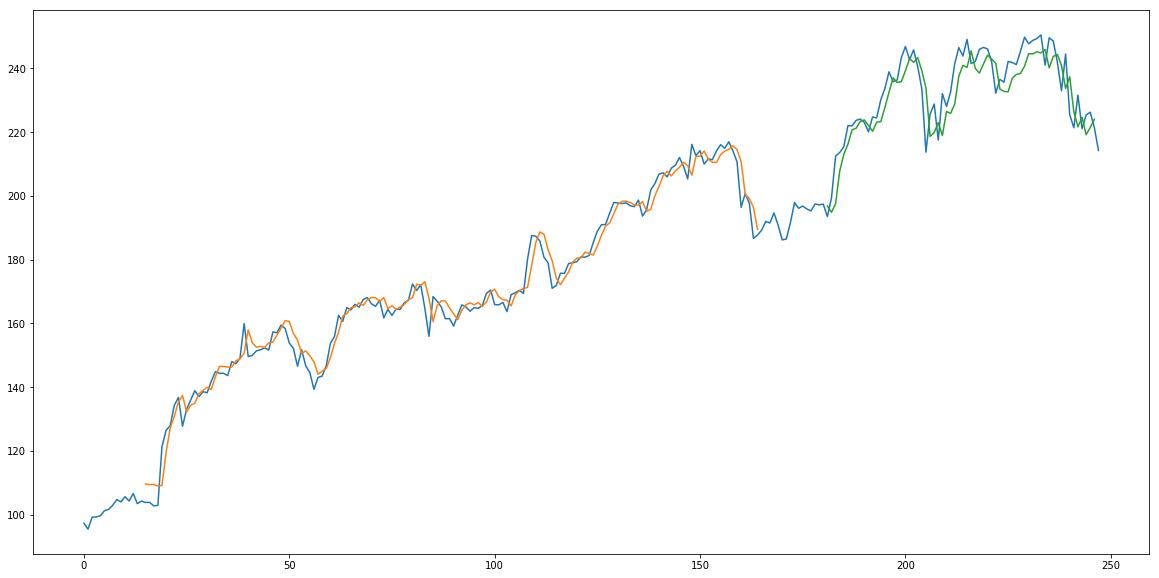

In [38]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [39]:
train2 = dataset
trainX2, trainY2 = create_dataset(train2, look_back)
trainX2 = numpy.reshape(trainX2, (trainX2.shape[0], 1, trainX2.shape[1]))
trainX2.shape, trainY2.shape

((232, 1, 15), (232,))

In [40]:
model2 = Sequential()
model2.add(LSTM(64, input_shape=(1, look_back)))
model2.add(Dropout(0.3))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')
model2.fit(trainX2, trainY2, epochs=200, batch_size=1, verbose=2)

Epoch 1/200
 - 1s - loss: 0.0266
Epoch 2/200
 - 0s - loss: 0.0085
Epoch 3/200
 - 0s - loss: 0.0082
Epoch 4/200
 - 0s - loss: 0.0078
Epoch 5/200
 - 0s - loss: 0.0081
Epoch 6/200
 - 0s - loss: 0.0067
Epoch 7/200
 - 0s - loss: 0.0063
Epoch 8/200
 - 0s - loss: 0.0059
Epoch 9/200
 - 0s - loss: 0.0046
Epoch 10/200
 - 0s - loss: 0.0054
Epoch 11/200
 - 0s - loss: 0.0063
Epoch 12/200
 - 0s - loss: 0.0054
Epoch 13/200
 - 0s - loss: 0.0053
Epoch 14/200
 - 0s - loss: 0.0041
Epoch 15/200
 - 0s - loss: 0.0047
Epoch 16/200
 - 0s - loss: 0.0041
Epoch 17/200
 - 0s - loss: 0.0041
Epoch 18/200
 - 0s - loss: 0.0052
Epoch 19/200
 - 0s - loss: 0.0042
Epoch 20/200
 - 0s - loss: 0.0040
Epoch 21/200
 - 0s - loss: 0.0045
Epoch 22/200
 - 0s - loss: 0.0036
Epoch 23/200
 - 0s - loss: 0.0053
Epoch 24/200
 - 0s - loss: 0.0048
Epoch 25/200
 - 0s - loss: 0.0037
Epoch 26/200
 - 0s - loss: 0.0035
Epoch 27/200
 - 0s - loss: 0.0041
Epoch 28/200
 - 0s - loss: 0.0038
Epoch 29/200
 - 0s - loss: 0.0038
Epoch 30/200
 - 0s - lo

In [41]:
# make predictions
trainPredict2 = model2.predict(trainX2)
# invert predictions
trainPredict2 = scaler.inverse_transform(trainPredict2)
trainY2 = scaler.inverse_transform([trainY2])
# calculate root mean squared error
trainScore2 = math.sqrt(mean_squared_error(trainY2, trainPredict2.T))
print('Train Score2: %.2f RMSE' % (trainScore2))

Train Score2: 5.08 RMSE


In [42]:
trainY2.shape, trainPredict2.shape

((1, 232), (232, 1))

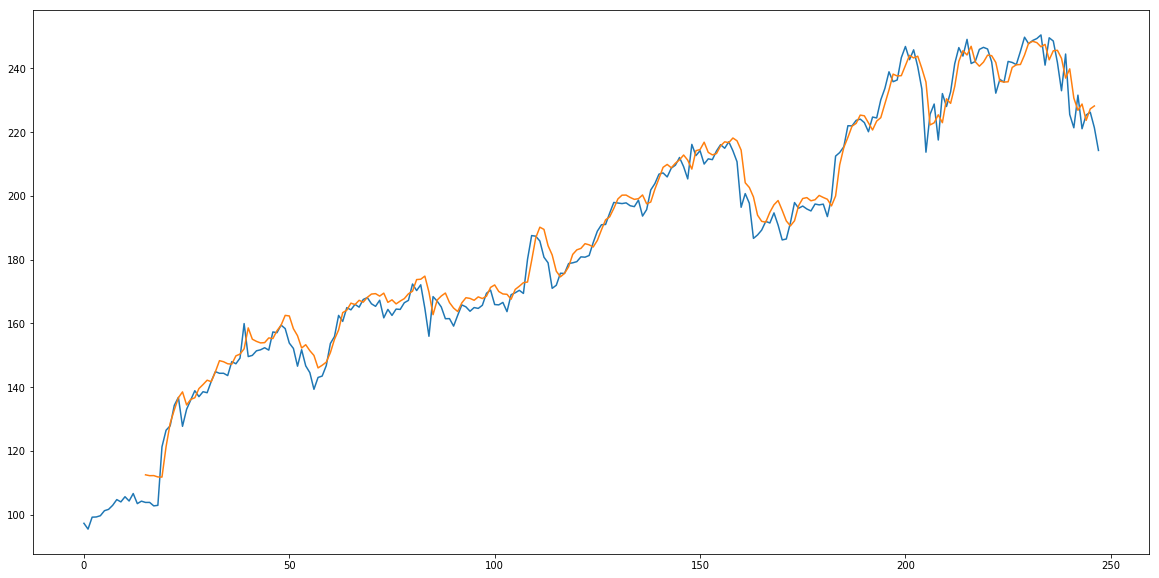

In [43]:
# shift train predictions for plotting
trainPredictPlot2 = numpy.empty_like(dataset)
trainPredictPlot2[:, :] = numpy.nan
trainPredictPlot2[look_back:len(trainPredict2)+look_back, :] = trainPredict2

# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot2)
plt.show()

In [44]:
import pandas as pd
#from plotly.plotly import plot_mpl
#from statsmodels.tsa.seasonal import seasonal_decompose

In [45]:
#trainPredict2 = pd.DataFrame(trainPredict2)
#result = seasonal_decompose(trainPredict2, model='multiplicative')
#fig = result.plot()
#plot_mpl(fig)

In [46]:
numpy.savetxt("LSTM_Predicted.csv", trainPredict2, delimiter=",")

In [47]:
stepwise_model = auto_arima(trainPredict2, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1148.937, BIC=1166.170, Fit time=0.462 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1219.676, BIC=1233.463, Fit time=0.141 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1151.390, BIC=1165.177, Fit time=0.370 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1148.970, BIC=1169.651, Fit time=0.593 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1288.042, BIC=1301.829, Fit time=0.078 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=1150.786, BIC=1171.466, Fit time=0.805 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=1151.039, BIC=1175.166, Fit time=1.258 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=1

In [48]:
print(stepwise_model.aic())

1147.29241721


In [49]:
n_periods = 30
future_forecast = stepwise_model.predict(n_periods=n_periods)
print(future_forecast)
trainPredict2full = numpy.append(trainPredict2,future_forecast)

[ 229.77562046  231.01579162  231.93493834  232.81936281  234.03684739
  233.40300725  232.46586947  231.43265047  229.52007272  228.95481734
  229.26436478  228.98865451  229.75706071  229.41931338  231.20813093
  231.02688964  231.26878492  232.28078473  232.5951939   232.4314819
  231.66545554  230.77131905  229.14821716  228.68596176  228.97114014
  228.81370769  229.37148647  228.90904634  230.39064751  229.98308395]


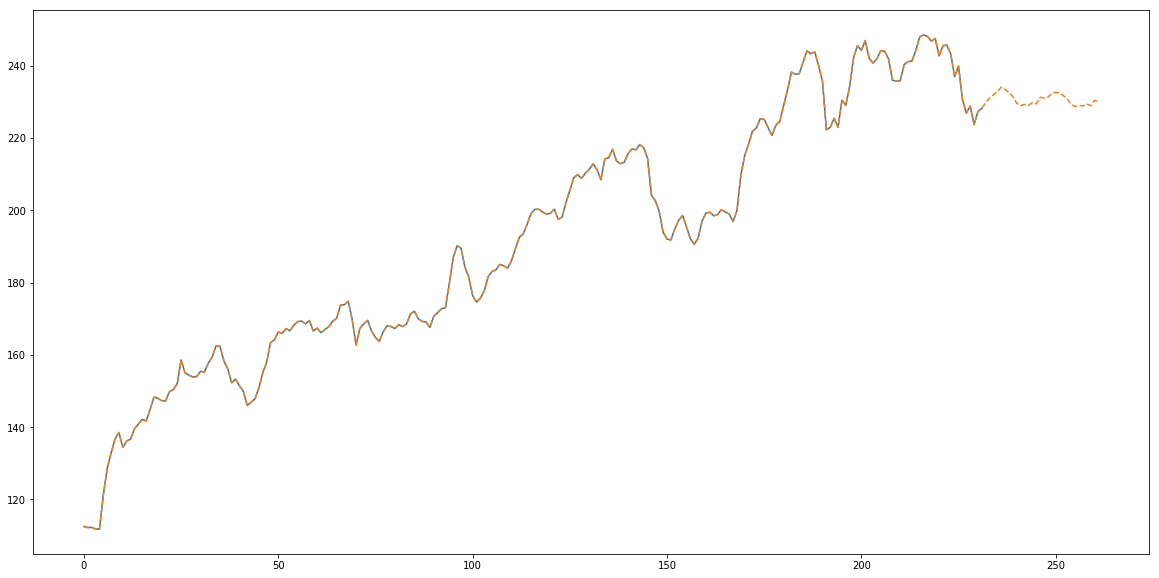

In [50]:
plt.figure(figsize=(20,10))
plt.plot(trainPredict2)
plt.plot(trainPredict2full, '--')
plt.show()